In [1]:
import sys
import numpy as np
np.set_printoptions(suppress=True)
# np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.style.use('ggplot')
from itertools import zip_longest
from sklearn.utils import shuffle
from sklearn.datasets import load_digits
import random
import pandas as pd
from numba import njit

In [2]:
SEED = 8
random.seed(SEED)
def shuffle_forward(l):
    order = list(range(len(l)))
    random.shuffle(order)
    return np.array(np.array(l)[order]), order

def shuffle_backward(l, order):
    l_out = [0] * len(l)
    for i, j in enumerate(order):
        l_out[j] = l[i]
    return l_out

# Optimized Functions with Numba

In [3]:
@njit
def nb_LIF(I, dT, V_rest, V_thresh, V_spike, Rm, Cm):
        """
        Runs a LIF simulation on neuron and returns outputted voltage

                Parameters:
                        I (double[]): A numpy array of input voltages in mV

                Returns:
                        V (double[]): A numpy array of the output voltages in mV
        """
        total_time = I.size * dT

        # an array of time
        time = np.arange(0, total_time, dT)

        # default voltage list set to resting volatage of -65mV
        V = V_rest * np.ones(len(time))

        did_spike = False

        for t in range(len(time)):
            # using "I - V(t)/Rm = Cm * dV/dT"
            dV = (I[t] - (V[t - 1] - V_rest) / Rm) / Cm

            # reset membrane potential if neuron spiked last tick
            if did_spike:
                V[t] = V_rest + dV * dT
            else:
                V[t] = V[t - 1] + dV * dT

            # check if membrane voltage exceeded threshold (spike)
            if V[t] > V_thresh:
                did_spike = True
                # set the last step to spike value
                V[t] = V_spike
            else:
                did_spike = False

        return V

@njit
def nb_voltage_to_output(V_input, V_spike):
    """Converts a neuron's internal voltage to output"""
    V_output = np.zeros(V_input.shape)
    for i, v in enumerate(V_input):
        V_output[i] = 0 if v < V_spike else V_spike
    return V_output

@njit
def nb_voltage_to_spike_rate(voltages, V_spike, dT, rate):
    """Converts an array of neuron voltages to spikes per n seconds, where n = rate"""
#         print('voltages', voltages)
    
    spike_count = 0
    for v in voltages:
        if v >= V_spike:
            spike_count += 1

    #         print('spike_count', spike_count)

    total_time_dT = len(voltages) * dT
    #         print(f'total_time_dT: {total_time_dT} ({dT}ms)')

    spikes_per_dT = spike_count / total_time_dT
    #         print(f'spikes_per_ms: {spikes_per_dT} (spikes/ms)')

    return spikes_per_dT * 1000 * rate

@njit
def nb_new_weight(weight, a_corr, input_rate, output_rate, w_max, w_decay):
    # adjust the weight using Hebb with decay
    weight_change = a_corr * input_rate * output_rate - w_decay
#                         print('\told weight', weight)
#                         print('\tweight_change:', weight_change)
    new_weight = 0
    if weight + weight_change < 0:
        new_weight = 0
    elif weight + weight_change > w_max:
        new_weight = w_max
    else:
        new_weight = weight + weight_change
    return new_weight

In [4]:
class SingleLayerSNN:
    def __init__(
        self,
        inputs,
        weights,
        trainings,
        Cm=4.0,
        Rm=5.0,
        V_thresh=30.0,
        V_rest=-65.0,
        V_spike=80.0,
        dT=0.01,
        rate=1.0,
    ):
        """
        Runs a LIF simulation on neuron and returns outputted voltage

                Parameters:
                        inputs (double[][][]): A 3d numpy array of the input voltages per timestep
                        weights (double[]): A numpy array of initial weights
                        outputs (double[][][]): A 3d numpy array of the output voltages per timestep used for teaching neuron
                Returns:
                        None
        """

        assert len(trainings) == len(inputs)

        self.inputs = inputs
        self.weights = weights
        self.trainings = trainings
        self.Cm = Cm
        self.Rm = Rm
        self.V_thresh = V_thresh
        self.V_rest = V_rest
        self.V_spike = V_spike
        self.dT = dT  # ms
        self.rate = rate  # sec
        self._LIF_spikes = 0
    
    def LIF(self, I):
        """
        Runs a LIF simulation on neuron and returns outputted voltage

                Parameters:
                        I (double[]): A numpy array of input voltages in mV

                Returns:
                        V (double[]): A numpy array of the output voltages in mV
        """
        return nb_LIF(I, self.dT, self.V_rest, self.V_thresh, self.V_spike, self.Rm, self.Cm)
    
    def voltage_to_output(self, V_input):
        """Converts a neuron's internal voltage to output"""
        return nb_voltage_to_output(V_input, self.V_spike)

    def voltage_to_spike_rate(self, voltages, dT=None, rate=None):
        """Converts an array of neuron voltages to spikes per n seconds, where n = rate"""
        if not dT:
            dT = self.dT
        if not rate:
            rate = self.rate
            
        return nb_voltage_to_spike_rate(voltages, self.V_spike, dT, rate)

    # returns the voltages of input and output neurons
    def feed_forward(self, inputs, train=True):
        """
        Passes all sets of inputs to 

                Parameters:
                        inputs (double[][][]): A 3d numpy array that contains every set of inputs voltages for each input neuron
                        train (boolean): Determines whether or not to inject training voltages

                Returns:
                        all_input_voltages, all_output_voltages (double[][][], double[][][]): A tuple of all of the input voltages and all of the output voltages
        """
        all_input_voltages = np.zeros(inputs.shape)
        all_output_voltages = np.zeros(self.trainings.shape)[:len(inputs)]

        # set the training voltages to all zero if not running in training mode
        training_copy = (
            np.zeros(inputs.shape, np.ndarray)
            if not train
            else np.array(self.trainings)
        )
        #         print('training_copy:')
        #         print(training_copy)

        inputs_copy = np.array(inputs)
        #         print('inputs_copy:')
        #         print(inputs_copy)

        assert len(training_copy) == len(inputs_copy)

        zipped = list(zip(inputs_copy, training_copy))
        
        shuffled, order = shuffle_forward(zipped)
        shuffled_inputs, shuffled_trainings = zip(*shuffled)

        shuffled_inputs = np.array(shuffled_inputs)
        #         print('shuffled_inputs:')
        #         print(shuffled_inputs)

        shuffled_trainings = np.array(shuffled_trainings)
        #         print('shuffled_trainings:')
        #         print(shuffled_trainings)
        
        # feed inputs through input neurons to get weighted voltage for output neurons
        for i, (input_set, training_set) in enumerate(zip_longest(shuffled_inputs, shuffled_trainings)):
            
            for j, V_input in enumerate(input_set):
                temp = np.array(V_input)
                all_input_voltages[i][j] = self.LIF(temp.astype(float))
            input_voltages = all_input_voltages[i]
            
            output_inputs = np.zeros(self.trainings[0].shape)
#             input_outputs = []  # DEBUG ONLY
            for j, weight_set in enumerate(self.weights.T):
                weighted_sum = np.zeros(len(input_set[0]))
                for V_input, weight in zip(input_voltages, weight_set):
                    # filter for spikes b/c a neuron only outputs if it spikes
                    input_output = self.voltage_to_output(V_input)
#                     input_outputs.append(input_output)  # DEBUG ONLY
                    weighted = input_output * weight
                    weighted_sum = np.add(weighted_sum, weighted)

                output_inputs[j] = weighted_sum

#             input_outputs = np.array(input_outputs)

            #             print('input_voltages:')
            #             print(input_voltages)
            #             print('input_outputs:')
            #             print(input_outputs)
            #             print('output_inputs:')
            #             print(output_inputs)
            #             print('training_set:')
            #             print(training_set)

            # inject training voltage if in training mode
            assert isinstance(training_set, (list, np.ndarray))
            for j, (output_input, training_input) in enumerate(
                zip(output_inputs, training_set)
            ):
                assert isinstance(training_input, (list, np.ndarray))
#               padded_training_input = np.pad(training_input, (0, len(output_inputs) - len(training_set)), "constant")
                output_inputs[j] = output_input + training_input

#             print('output_inputs after injecting training current')
#             print(output_inputs)

            # run LIF on output neurons
            for j, V_input in enumerate(output_inputs):
                all_output_voltages[i][j] = self.LIF(V_input)
                            
#             output_voltages = all_output_voltages[i]
#             print('output_voltages:')
#             print(output_voltages)

        # unshuffle the voltages
        all_input_voltages = np.array(shuffle_backward(all_input_voltages, order))
        all_output_voltages = np.array(shuffle_backward(all_output_voltages, order))
        return all_input_voltages, all_output_voltages

    def train(self, epochs=75, a_corr=0.000000002, w_max=2, w_decay=0, show_legend=True, print_weights=True, print_progress=True):
        """Runs feed forward with training dataset"""
        weights_history = []
        for weight_set in self.weights:
            weight_row = []
            for weight in weight_set:
                weight_row.append([weight])
            weights_history.append(weight_row)

        for epoch in range(epochs):
            print_progress and print(f"Epoch: {epoch + 1}")
            
            print_progress and print('\trunning feed forward...')
            
            all_input_voltages, all_output_voltages = self.feed_forward(
                self.inputs, train=True
            )

            # debug info
            #             print()
            #             print('------------------------------------------------')
            #             print('all_input_voltages:')
            #             print(all_input_voltages)
            #             print('all_output_voltages:')
            #             print(all_output_voltages)

            #             print('weights:')
            #             print(self.weights)
            
            print_progress and print('\tapplying learning rule...')
            # apply learning rule
            for input_voltages, output_voltages in zip(
                all_input_voltages, all_output_voltages
            ):
#                 print('input_voltages:')
#                 print(input_voltages)
                for i, (input_voltage_set, weight_set) in enumerate(
                    zip(input_voltages, self.weights)
                ):
#                     print('input_voltage_set', input_voltage_set)
                    input_rate = self.voltage_to_spike_rate(input_voltage_set)
#                     print(f'input_rate {i}:', input_rate)

                    for j, (output_voltage_set, weight) in enumerate(
                        zip(output_voltages, weight_set)
                    ):
                        output_rate = self.voltage_to_spike_rate(output_voltage_set)
#                         print(f'\toutput_rate {j}:', output_rate)

                        # adjust the weight using Hebb with decay
                        self.weights[i][j] = nb_new_weight(self.weights[i][j], a_corr, input_rate, output_rate, w_max, w_decay)

#                         print('\tnew weight', self.weights[i][j], '\n')

            # update weight history
            for i, weight_set in enumerate(self.weights):
                for j, weight in enumerate(weight_set):
                    weights_history[i][j].append(weight)
            if print_weights:
                print('\tweights:')
                print('\t' + str(self.weights).replace('\n','\n\t'))

        # plot neuron spiking data
        #             for i, (input_voltages, output_voltages) in enumerate(zip(all_input_voltages, all_output_voltages)):
        #                 plt.figure(figsize=(20,10))
        #                 plt.title(f'Input: {i + 1}')
        #                 for input_voltage in input_voltages:
        #                     plt.plot(input_voltage, 'b:', alpha=.5)

        #                 for output_voltage in output_voltages:
        #                     plt.plot(output_voltage, 'r--', alpha=.5)

        #             plt.show()

        # plot weights history
        plt.figure(figsize=(20, 10))
        for i, weight_row in enumerate(weights_history):
            for j, weight_history in enumerate(weight_row):
                plt.plot(weight_history, label=f"weight {i}-{j}")
                plt.xlabel('Epoch')
        if show_legend:
            plt.legend(loc="upper left")
        plt.title("Weight History")
        plt.show()
        
    def _generate_bar_plot(self, outputs, title='', ylabel='', stacked=False, percents=False):
        d = {}
        """Generates bar plot for output neuron data"""
        for x, bars in enumerate(outputs.T):
            d[f'Output Neuron {x}'] = bars
        index = [f'{x}' for x in range(len(outputs.T[0]))]
        df = pd.DataFrame(d, index=index)
        ax = df.plot.bar(rot=0, figsize=(20, 10), stacked=stacked, title=title)
        ax.set_xlabel('Input Set')
        ax.set_ylabel(ylabel)
        if percents:
            ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    def predict(self, inputs, show_plots=True, print_neuron_rates=False):
        """Runs feed foward without training data on inputs"""
        all_input_voltages, all_output_voltages = self.feed_forward(inputs, train=False)
#         print('all_output_voltages')
#         print(all_output_voltages)

        all_output_confidences = []
        all_output_spike_rates = []

        for x, (input_voltages, output_voltages) in enumerate(
            zip(all_input_voltages, all_output_voltages)
        ):
            output_spike_rates = []
            output_confidences = []
            if print_neuron_rates:
                print("input set:", x)
                for i, input_voltage_set in enumerate(input_voltages):
                    print(
                        f"\tinput {i}: {self.voltage_to_spike_rate(input_voltage_set)} spikes/{self.rate}s"
                    )
                print()

            output_voltages_sum = sum(
                [self.voltage_to_spike_rate(v) for v in output_voltages]
            )
            
            for i, output_voltage_set in enumerate(output_voltages):
                sr = self.voltage_to_spike_rate(output_voltage_set)
                output_spike_rates.append(sr)
                confidence = (
                    "N/A" if output_voltages_sum == 0 else sr / output_voltages_sum
                )
                output_confidences.append(0 if confidence == "N/A" else confidence)
                if print_neuron_rates:
                    print(
                        f"\toutput {i}: {sr} spikes/{self.rate}s, confidence: {confidence}"
                    )
            if print_neuron_rates:
                print()
                
            all_output_spike_rates.append(output_spike_rates)
            all_output_confidences.append(output_confidences)

        all_output_confidences = np.array(all_output_confidences)
        all_output_spike_rates = np.array(all_output_spike_rates)

        #         print(all_output_confidences)
        #         print(all_output_spike_rates)
        if show_plots:
            # plot output confidence
            self._generate_bar_plot(
                all_output_confidences, title="Output Confidence", ylabel="Confidence", stacked=True, percents=True)
            # plot output spike rates
            self._generate_bar_plot(
                all_output_spike_rates,
                ylabel=f"Spike Rate (spikes/{self.rate}s)",
                title="Output Spike Rates",
            )
        return all_input_voltages, all_output_voltages, all_output_confidences, all_output_spike_rates


# Logical AND

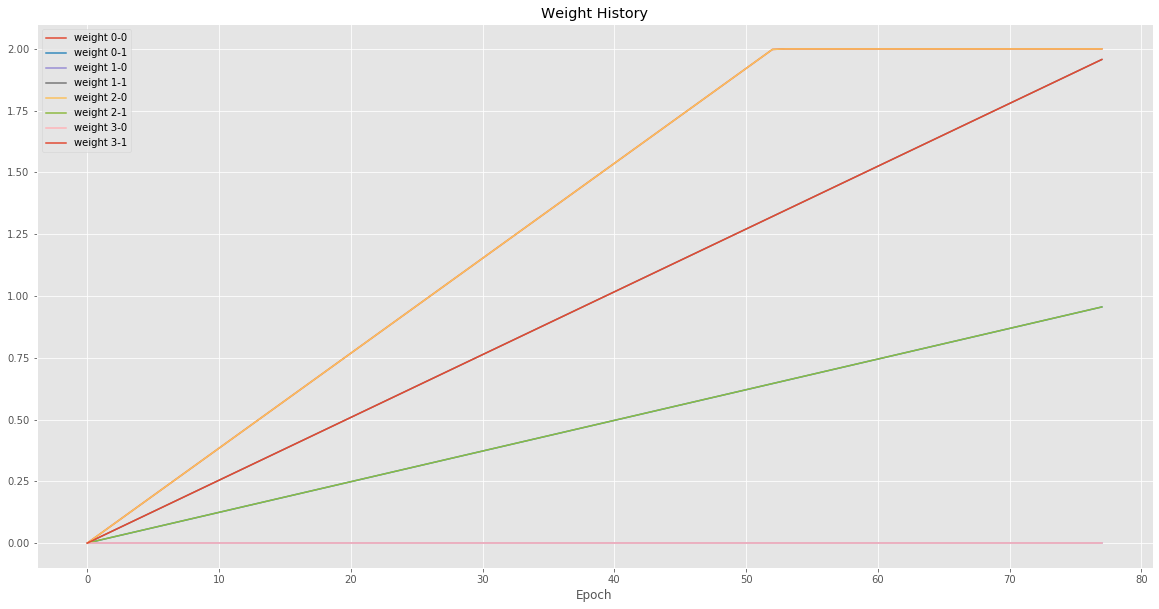

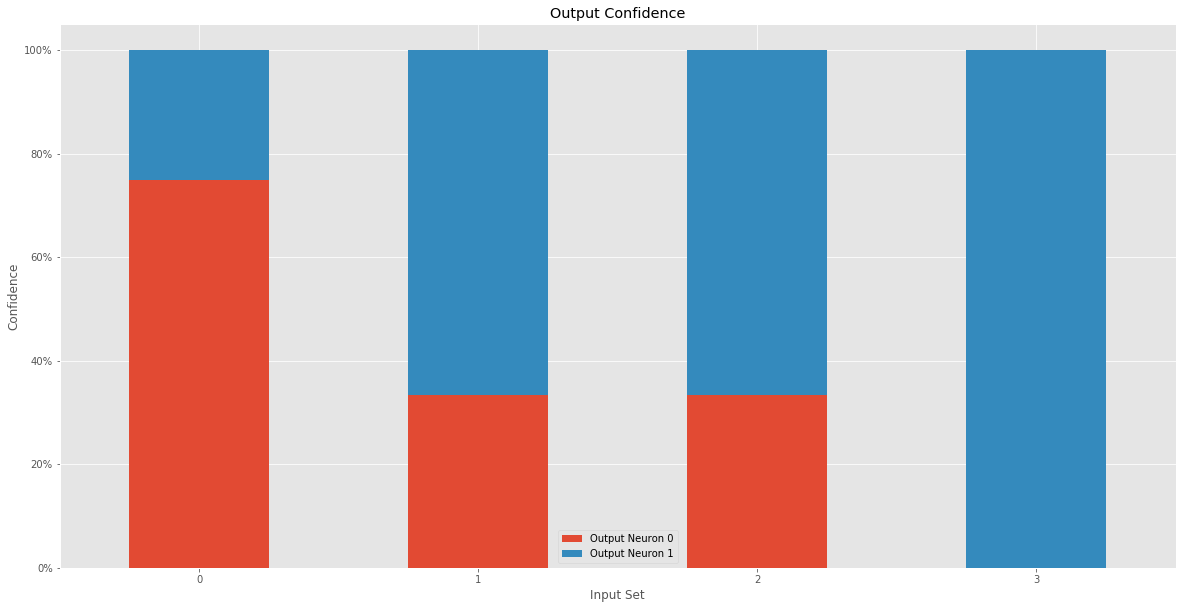

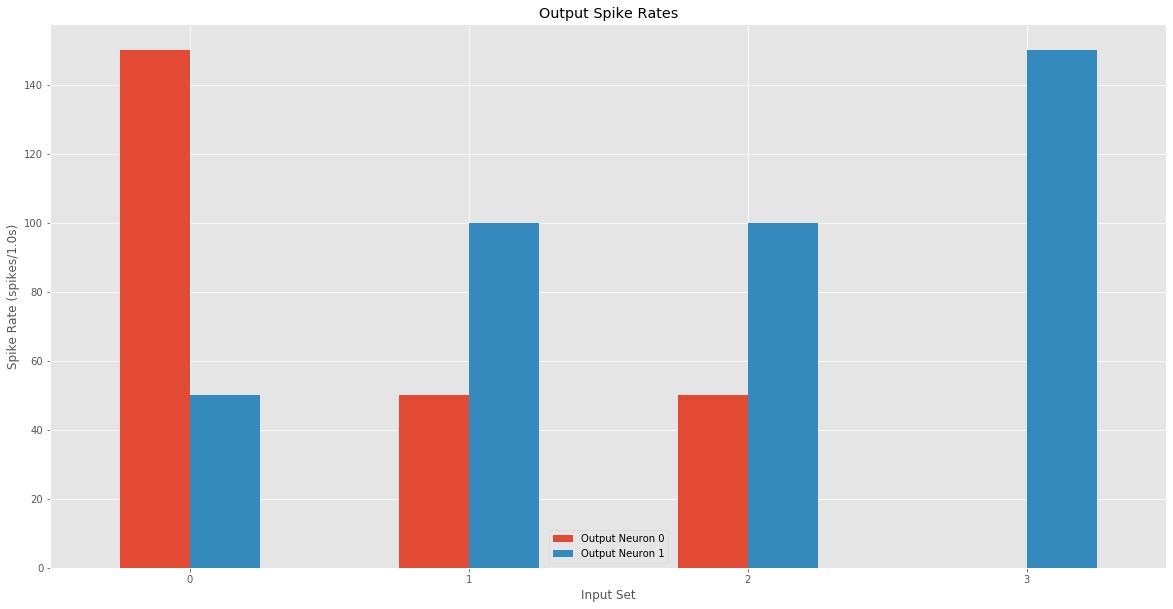

In [5]:
u_t = 2000  # units of time
i_a = 1000.0  # input amount

# NOTE: we want the same number of training inputs for each output class
inputs = np.array(
    [
        [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[i_a] * u_t, [0.0] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: T, y: F --> F
        [[0.0] * u_t, [i_a] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: F, y: T --> F
        [[0.0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: F, y: F --> F
    ]
)

t_a = 1000.0  # training amount
s_a = -100.0  # supress amount

# current that gets injected to the output neurons
trainings = np.array(
    [
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[s_a] * u_t, [t_a] * u_t],  # F
        [[s_a] * u_t, [t_a] * u_t],  # F
        [[s_a] * u_t, [t_a] * u_t],  # F
    ]
)

# initiate the weights to be half of max weight
weights = np.array(
    [
        [0.0, 0.0],
        [0.0, 0.0],
        [0.0, 0.0],
        [0.0, 0.0],
    ]
)

and_network = SingleLayerSNN(inputs=inputs, weights=weights, trainings=trainings)

# BEST: epochs=77, a_corr=0.000000002, w_max=2.0, w_decay=0.0001, print_weights=False, print_progress=False
and_network.train(epochs=77, a_corr=0.000000002, w_max=2.0, w_decay=0.0001, print_weights=False, print_progress=False)

p_a = 10000.0  # predict input amount

# the four possible cases
predict_inputs = np.array(
    [
        [[p_a] * u_t, [0.0] * u_t, [p_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[p_a] * u_t, [0.0] * u_t, [0.0] * u_t, [p_a] * u_t],  # x: T, y: F --> F
        [[0.0] * u_t, [p_a] * u_t, [p_a] * u_t, [0.0] * u_t],  # x: F, y: T --> F
        [[0.0] * u_t, [p_a] * u_t, [0.0] * u_t, [p_a] * u_t],  # x: F, y: F --> F
    ]
)

and_network.predict(predict_inputs);


# Logical OR

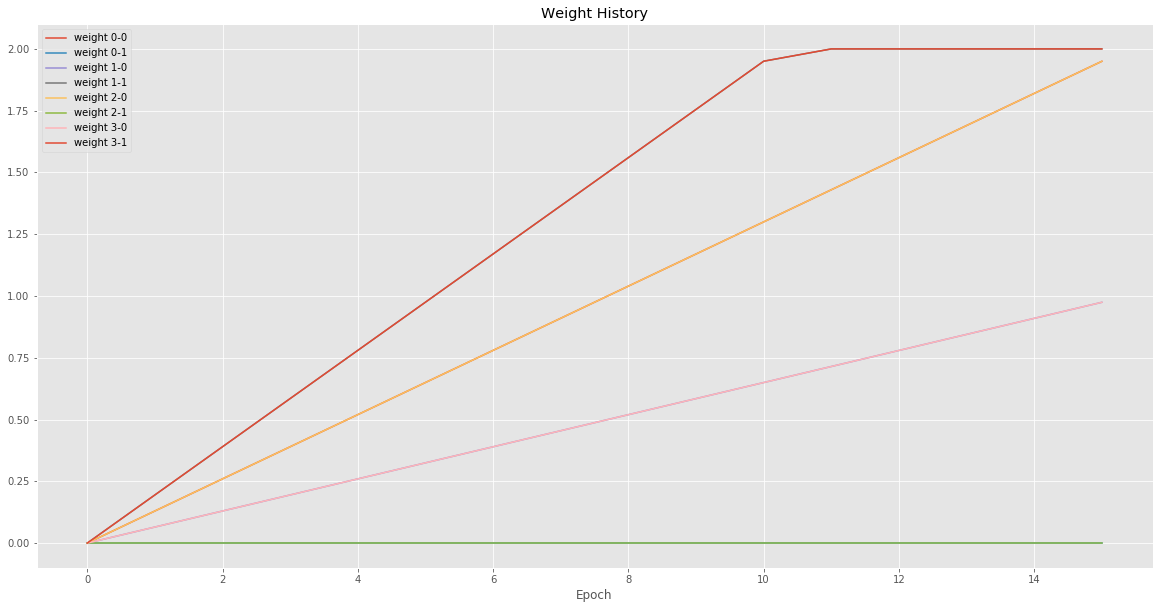

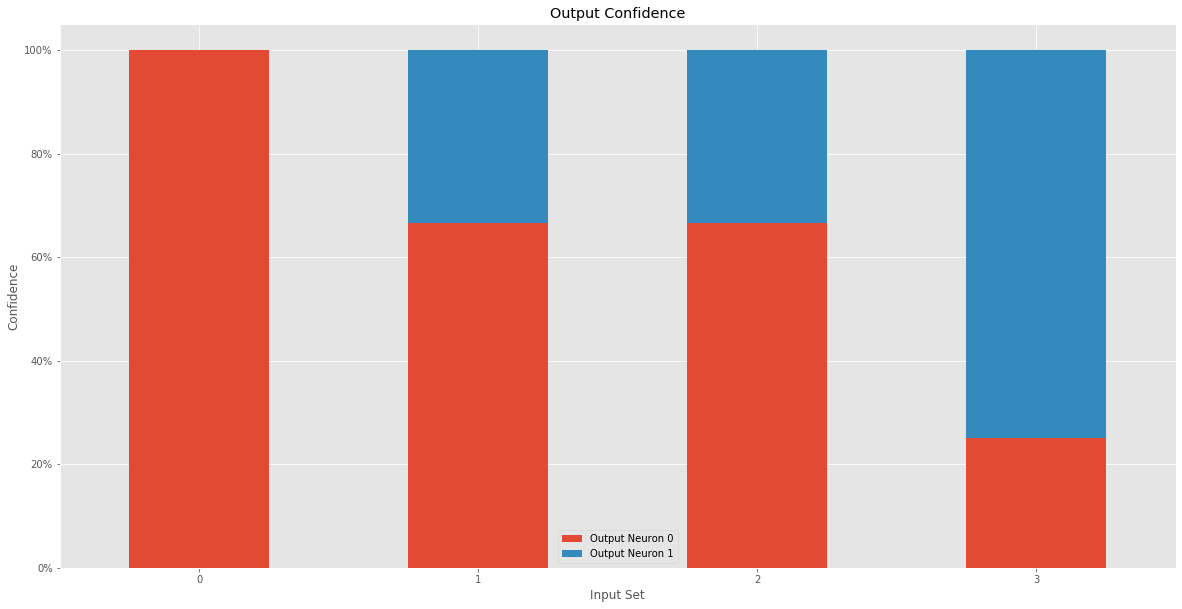

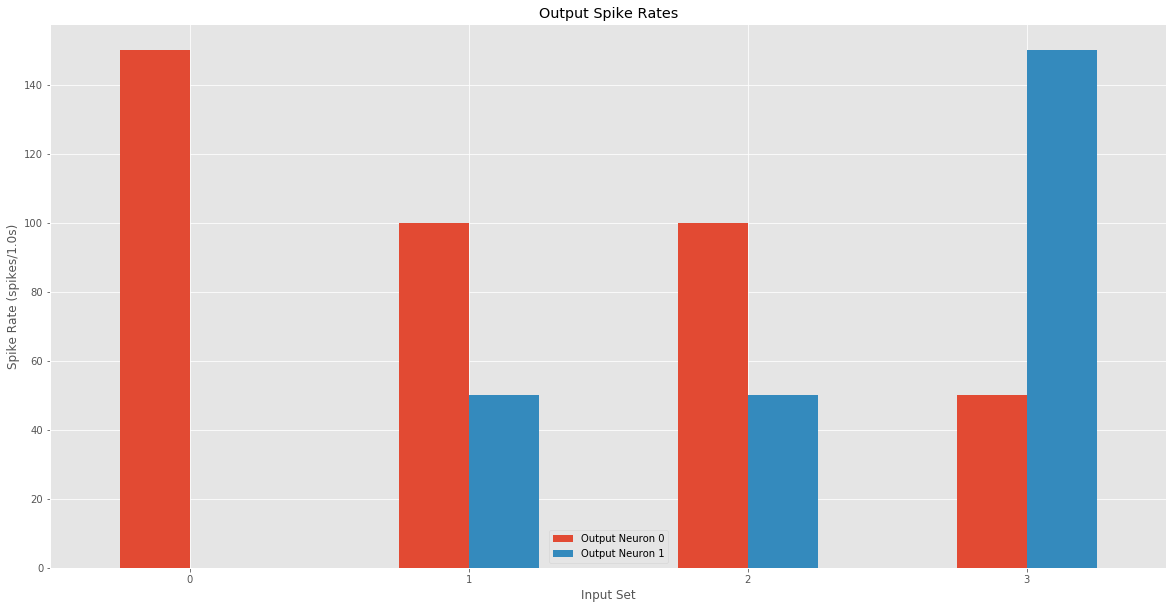

In [6]:
u_t = 2000  # units of time
i_a = 1000.0  # input amount

# NOTE: we want the same number of training inputs for each output class
inputs = np.array(
    [
        [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[i_a] * u_t, [0.0] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: T, y: F --> T
        [[0.0] * u_t, [i_a] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: F, y: T --> T
        [[0.0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: F, y: F --> F
        [[0.0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: F, y: F --> F
        [[0.0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: F, y: F --> F

    ]
)

t_a = 1000.0  # training amount
s_a = -100.0  # supress amount

# current that gets injected to the output neurons
trainings = np.array(
    [
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[s_a] * u_t, [t_a] * u_t],  # F
        [[s_a] * u_t, [t_a] * u_t],  # F
        [[s_a] * u_t, [t_a] * u_t],  # F
    ]
)

# initiate the weights to be half of max weight
weights = np.array(
    [
        [0.0, 0.0],
        [0.0, 0.0],
        [0.0, 0.0],
        [0.0, 0.0],
    ]
)

or_network = SingleLayerSNN(inputs=inputs, weights=weights, trainings=trainings)

# BEST PARAMS FOR OR NETWORK: epochs=15, a_corr=0.00000001, w_max=2.0, w_decay=0.00001
or_network.train(epochs=15, a_corr=0.00000001, w_max=2.0, w_decay=0.00001, print_weights=False, print_progress=False)

p_a = 10000.0  # predict input amount

# the four possible cases
predict_inputs = np.array(
    [
        [[p_a] * u_t, [0.0] * u_t, [p_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[p_a] * u_t, [0.0] * u_t, [0.0] * u_t, [p_a] * u_t],  # x: T, y: F --> T
        [[0.0] * u_t, [p_a] * u_t, [p_a] * u_t, [0.0] * u_t],  # x: F, y: T --> T
        [[0.0] * u_t, [p_a] * u_t, [0.0] * u_t, [p_a] * u_t],  # x: F, y: F --> F
    ]
)
or_network.predict(predict_inputs);


# Logical XOR

Epoch: 1
	running feed forward...
	applying learning rule...
Epoch: 2
	running feed forward...
	applying learning rule...
Epoch: 3
	running feed forward...
	applying learning rule...
Epoch: 4
	running feed forward...
	applying learning rule...
Epoch: 5
	running feed forward...
	applying learning rule...
Epoch: 6
	running feed forward...
	applying learning rule...
Epoch: 7
	running feed forward...
	applying learning rule...
Epoch: 8
	running feed forward...
	applying learning rule...
Epoch: 9
	running feed forward...
	applying learning rule...
Epoch: 10
	running feed forward...
	applying learning rule...
Epoch: 11
	running feed forward...
	applying learning rule...
Epoch: 12
	running feed forward...
	applying learning rule...
Epoch: 13
	running feed forward...
	applying learning rule...
Epoch: 14
	running feed forward...
	applying learning rule...
Epoch: 15
	running feed forward...
	applying learning rule...


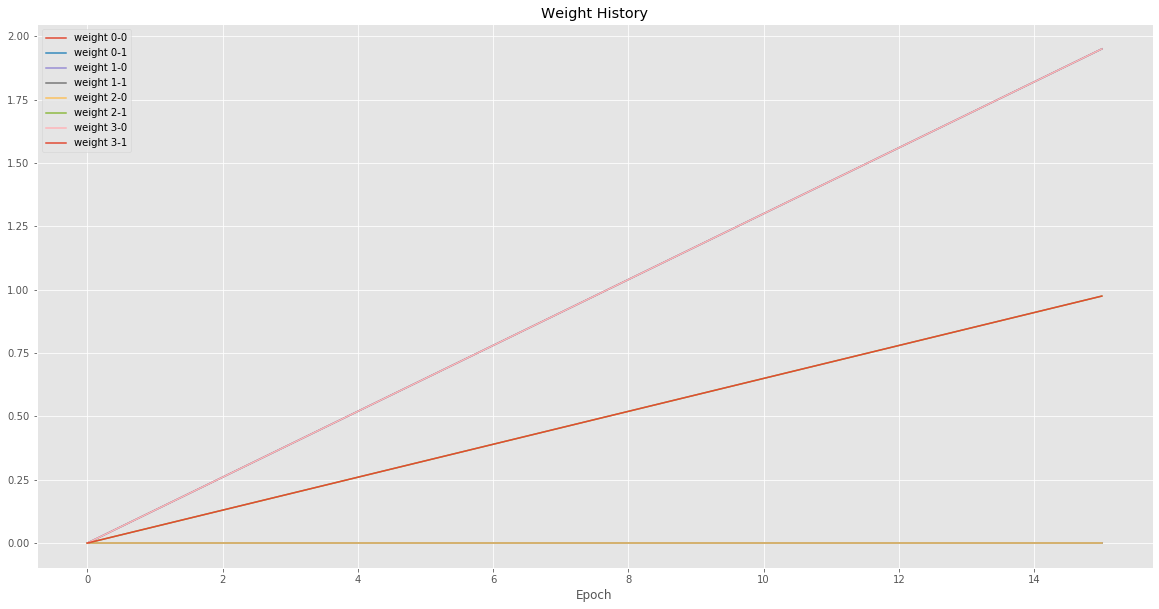

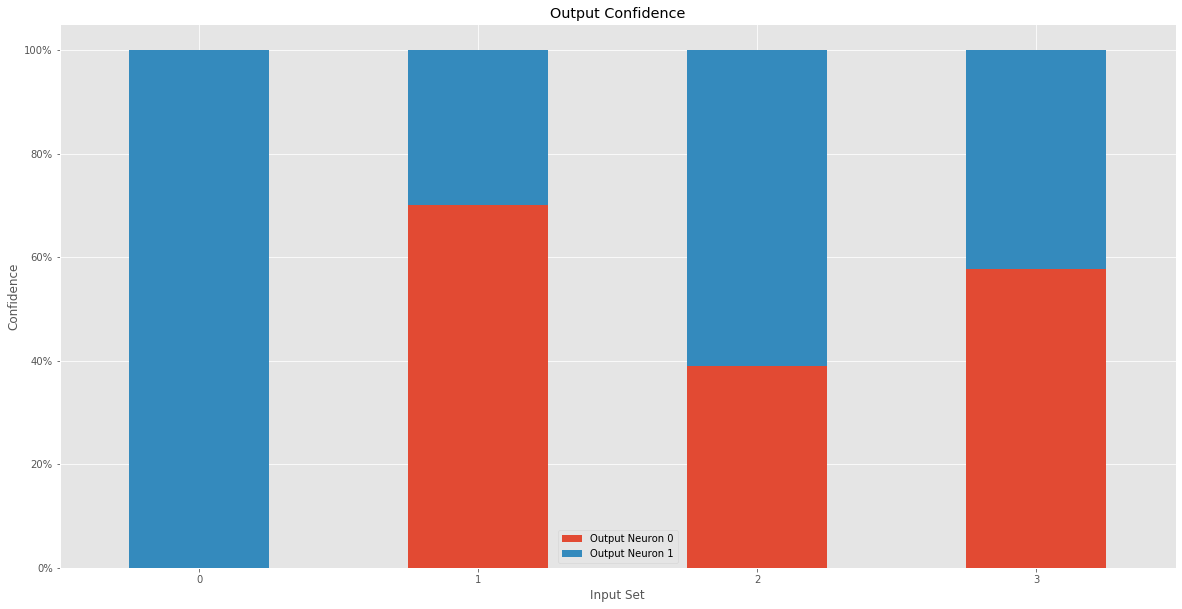

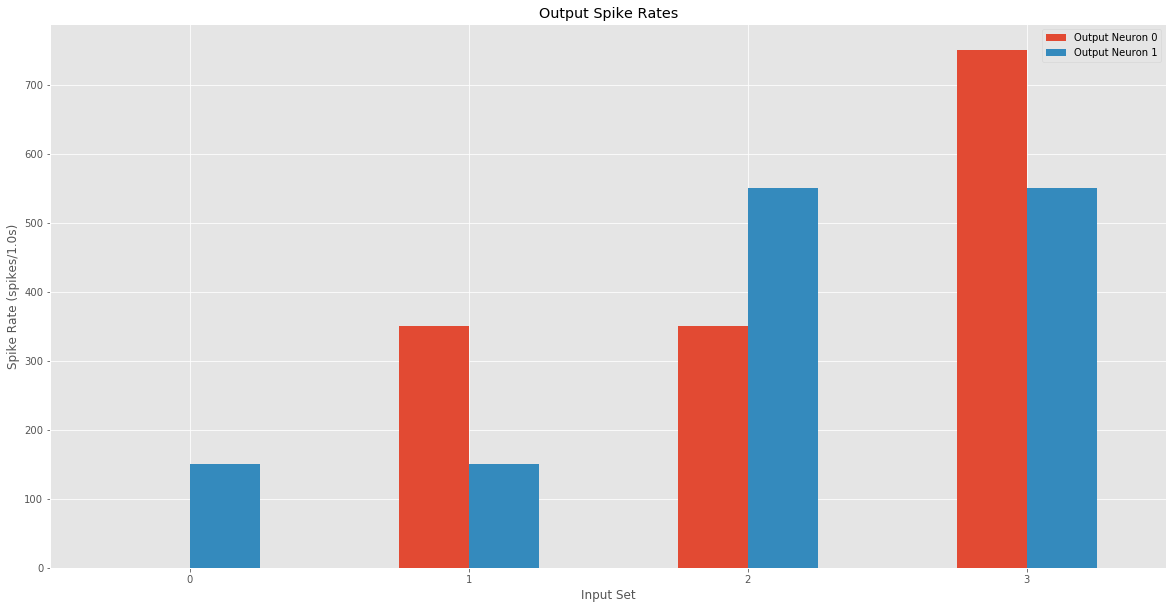

In [7]:
u_t = 2000  # units of time
i_a = 1000.0  # input amount

# NOTE: we want the same number of training inputs for each output class
inputs = np.array(
    [
        [[0.0] * u_t, [i_a] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: F, y: T --> F
        [[0.0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: F, y: F --> T
        [[0.0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: F, y: F --> T
        [[0.0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: F, y: F --> F

    ]
)

t_a = 1000.0  # training amount
s_a = -100.0  # supress amount

# current that gets injected to the output neurons
trainings = np.array(
    [
        [[s_a] * u_t, [t_a] * u_t],  # F
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[s_a] * u_t, [t_a] * u_t],  # F
    ]
)

# initiate the weights to be half of max weight
weights = np.array(
    [
        [0.0, 0.0],
        [0.0, 0.0],
        [0.0, 0.0],
        [0.0, 0.0],
    ]
)

xor_network = SingleLayerSNN(inputs=inputs, weights=weights, trainings=trainings)

# BEST PARAMS FOR OR NETWORK: epochs=15, a_corr=0.00000001, w_max=2.0, w_decay=0.00001
xor_network.train(epochs=15, a_corr=0.00000001, w_max=2.0, w_decay=0.00001, print_weights=False)

p_a = 100000.0  # predict input amount

# the four possible cases
predict_inputs = np.array(
    [
        [[p_a] * u_t, [0.0] * u_t, [p_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[p_a] * u_t, [0.0] * u_t, [0.0] * u_t, [p_a] * u_t],  # x: T, y: F --> T
        [[0.0] * u_t, [p_a] * u_t, [p_a] * u_t, [0.0] * u_t],  # x: F, y: T --> T
        [[0.0] * u_t, [p_a] * u_t, [0.0] * u_t, [p_a] * u_t],  # x: F, y: F --> F
    ]
)
xor_network.predict(predict_inputs);


# Digit Classification

In [8]:
def has_duplicate(l, n):
    seen = False
    for x in l:
        if x == n:
            if seen:
                return True
            else:
                seen = True
    return False

def digit_stats(all_output_spike_rates, digit_types, targets, title):
    assert len(all_output_spike_rates) == len(targets)
    unique_targets = set(targets)
    
    correct_digits_stats = {}
    encountered_digits_stats = {}
    for t in unique_targets:
        correct_digits_stats[t] = 0
        encountered_digits_stats[t] = 0        

    for output_spike_rates, target in zip(all_output_spike_rates, targets):
        encountered_digits_stats[target] += 1
        max_voltage = max(output_spike_rates)

        if not has_duplicate(output_spike_rates, max_voltage):

            max_voltage_index = np.where(output_spike_rates == max_voltage)

            if max_voltage_index == target:
                correct_digits_stats[target] += 1
                
    accuracy_stats = {}
    for t in unique_targets:
        accuracy_stats[t] = correct_digits_stats[t] / encountered_digits_stats[t]
        
    # plot the accuracy stats
    df = pd.DataFrame(accuracy_stats.values(), index=accuracy_stats.keys(), columns=['accuracy'])
    
    fig, ax = plt.subplots()
    
    df.plot(kind='bar', ax=ax, figsize=(20, 10), rot=0)
    
    ax.set_xlabel("Digit")
    ax.set_ylabel("Accuracy")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_title(title, fontsize=20)
    
    # show mean line
    mean = df["accuracy"].mean()
    ax.axhline(mean)
    
    # print out statistics
    print('Digit Accuracies')
    for t in unique_targets:
        print(f'\tDigit {t}: {accuracy_stats[t] * 100}%')
    
    print(f'Mean Accuracy: {mean * 100}%')
    return correct_digits_stats, encountered_digits_stats

In [9]:
digits = load_digits()

u_t = 2000 # units of time
t_a = 1000 # training injection amount
s_a = -100 # training supression amount

pixels_per_digit = len(digits.data[0])
intensity_multiplier = 500
digit_types = 10 # max: 10, min: 1

# preprocess data
complete_set = np.zeros((len(digits.data), pixels_per_digit, u_t), float)
trainings = np.zeros((len(digits.target), digit_types, u_t), float)

@njit
for i, (digit, target) in enumerate(zip(digits.data, digits.target)):
    digit_voltage_stream = np.zeros((pixels_per_digit, u_t), float)
    training_voltage_stream = np.zeros((digit_types, u_t), float)
    
    for j, pixel in enumerate(digit):
        digit_voltage_stream[j] = np.array([pixel * intensity_multiplier] * u_t)
         
    assert target < digit_types
    for j in range(digit_types):
        training_voltage_stream[j] = np.array([t_a] * u_t) if j == target else np.array([s_a] * u_t)
        
    complete_set[i] = digit_voltage_stream
    trainings[i] = training_voltage_stream

assert len(trainings) == len(complete_set)    

In [10]:
# get all eights
eight_indexes = np.where(digits.target == 8)
eight_set, = np.take(complete_set, eight_indexes, axis=0)
eight_trainings, = np.take(trainings, eight_indexes, axis=0)
eight_targets, = np.take(digits.target, eight_indexes, axis=0)

# get all ones
one_indexes = np.where(digits.target == 1)
one_set, = np.take(complete_set, one_indexes, axis=0)
one_images, = np.take(digits.images, one_indexes, axis=0)
one_trainings, = np.take(trainings, one_indexes, axis=0)
one_targets, = np.take(digits.target, one_indexes, axis=0)

# get all threes
three_indexes = np.where(digits.target == 3)
three_set, = np.take(complete_set, three_indexes, axis=0)
three_images, = np.take(digits.images, three_indexes, axis=0)
three_trainings, = np.take(trainings, three_indexes, axis=0)
three_targets, = np.take(digits.target, three_indexes, axis=0)

# for x in three_images:
#     plt.figure(1, figsize=(3, 3))
#     plt.imshow(x, cmap=plt.cm.gray_r, interpolation='nearest')
#     plt.show()


Epoch: 1
	running feed forward...
	applying learning rule...
Epoch: 2
	running feed forward...
	applying learning rule...
Epoch: 3
	running feed forward...
	applying learning rule...
Epoch: 4
	running feed forward...
	applying learning rule...
Epoch: 5
	running feed forward...
	applying learning rule...
Epoch: 6
	running feed forward...
	applying learning rule...
Epoch: 7
	running feed forward...
	applying learning rule...
Epoch: 8
	running feed forward...
	applying learning rule...
Epoch: 9
	running feed forward...
	applying learning rule...
Epoch: 10
	running feed forward...
	applying learning rule...
Epoch: 11
	running feed forward...
	applying learning rule...
Epoch: 12
	running feed forward...
	applying learning rule...
Epoch: 13
	running feed forward...
	applying learning rule...
Epoch: 14
	running feed forward...
	applying learning rule...
Epoch: 15
	running feed forward...
	applying learning rule...
Epoch: 16
	running feed forward...
	applying learning rule...
Epoch: 17
	runnin

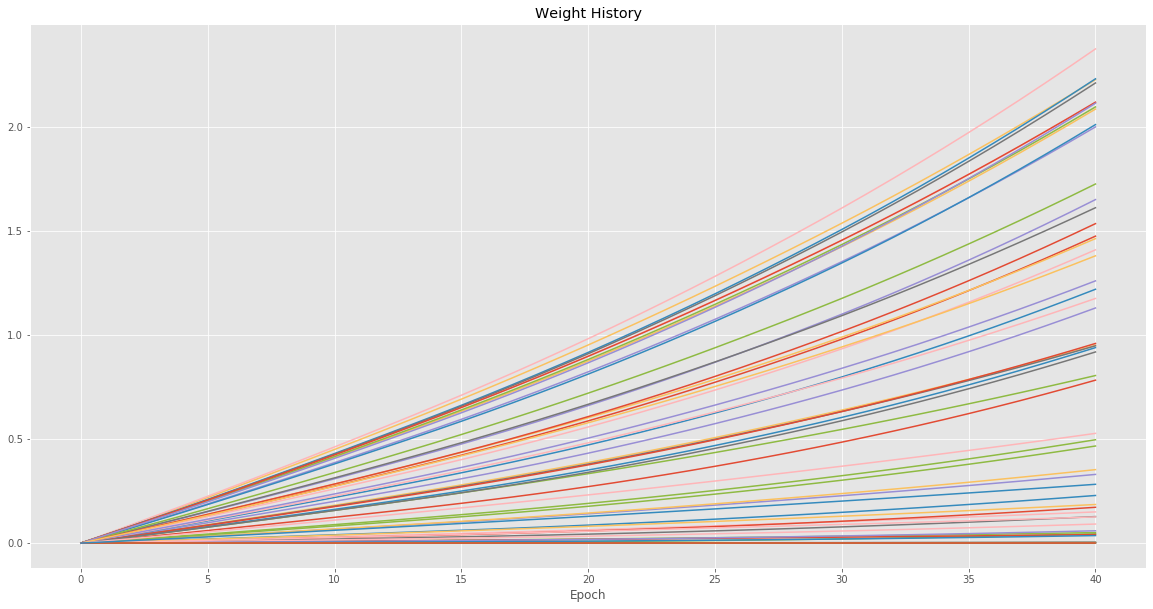

Digit Accuracies
	Digit 8: 0.0%
	Digit 1: 100.0%
Mean Accuracy: 50.0%


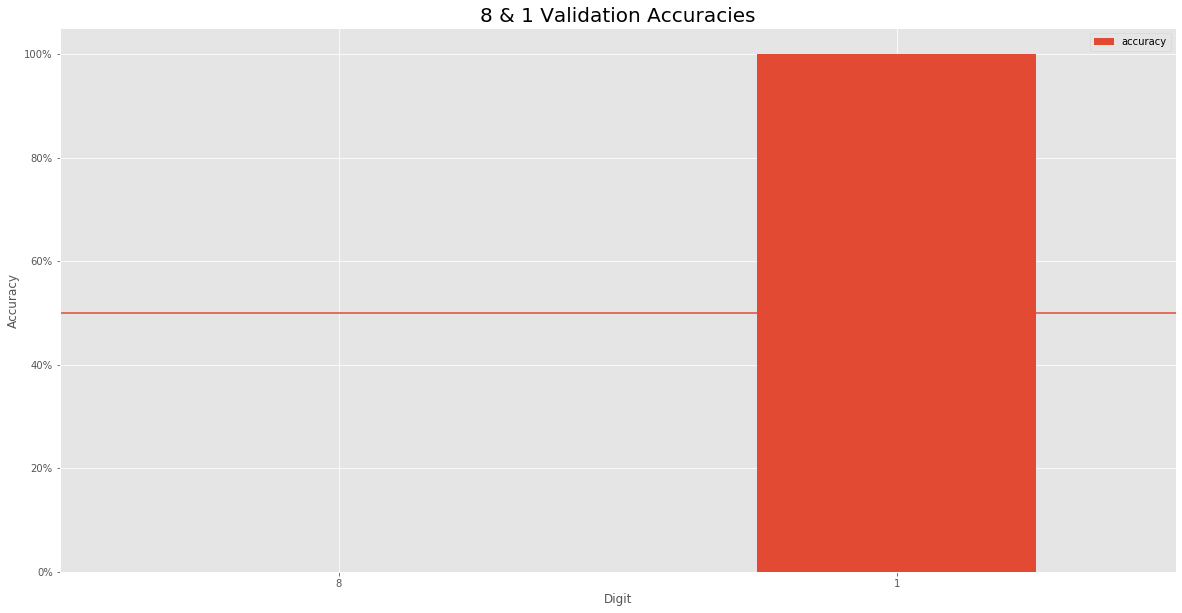

In [11]:
# train on eight and one
eight_one_set = np.vstack((eight_set, one_set))
eight_one_trainings = np.vstack((eight_trainings, one_trainings))
eight_one_targets = np.concatenate((eight_targets, one_targets))

eo_train_set = eight_one_set[:-50]
eo_train_trainings = eight_one_trainings[:-50]

eo_val_set = eight_one_set[:-150]
eo_val_targets =eight_one_targets[:-150]

eo_test_set = eight_one_set[len(eight_one_set) - 50:]
eo_test_targets =eight_one_targets[len(eight_one_set) - 50:]


eo_weights = np.zeros((pixels_per_digit, 2))

eo_network = SingleLayerSNN(inputs=eo_train_set, weights=eo_weights, trainings=eo_train_trainings)
eo_network.train(epochs=40, a_corr=0.000000000007, w_max=5, w_decay=0.000000, show_legend=False, print_weights=False)

_, _, all_output_confidences, eo_all_output_spike_rates = eo_network.predict(inputs=eo_val_set, show_plots=False)
digit_stats(eo_all_output_spike_rates, digit_types=2, targets=eo_val_targets, title='8 & 1 Validation Accuracies');


In [15]:
# train on three and one
eight_three_set = np.vstack((eight_set, three_set))
eight_three_trainings = np.vstack((eight_trainings, three_trainings))
eight_three_targets = np.concatenate((eight_targets, three_targets))

et_train_set = eight_three_set[:-50]
et_train_trainings = eight_three_trainings[:-50]

et_val_set = eight_three_set[:-150]
et_val_targets = eight_three_targets[:-150]

et_test_set = eight_three_set[len(eight_three_set) - 50:]
et_test_targets = eight_three_targets[len(eight_three_set) - 50:]

et_weights = np.zeros((pixels_per_digit, 2))

et_network = SingleLayerSNN(inputs=et_train_set, weights=et_weights, trainings=et_train_trainings)
et_network.train(epochs=10, a_corr=1.0, w_max=2, w_decay=0.000000, show_legend=False, print_weights=True)

_, _, _, et_all_output_spike_rates = et_network.predict(inputs=et_val_set, show_plots=False)
digit_stats(et_all_output_spike_rates, digit_types=2, targets=et_val_targets, title='8 & 3 Validation Accuracies');


[[[-100. -100. -100. ... -100. -100. -100.]
  [-100. -100. -100. ... -100. -100. -100.]
  [-100. -100. -100. ... -100. -100. -100.]
  ...
  [-100. -100. -100. ... -100. -100. -100.]
  [1000. 1000. 1000. ... 1000. 1000. 1000.]
  [-100. -100. -100. ... -100. -100. -100.]]

 [[-100. -100. -100. ... -100. -100. -100.]
  [-100. -100. -100. ... -100. -100. -100.]
  [-100. -100. -100. ... -100. -100. -100.]
  ...
  [-100. -100. -100. ... -100. -100. -100.]
  [1000. 1000. 1000. ... 1000. 1000. 1000.]
  [-100. -100. -100. ... -100. -100. -100.]]

 [[-100. -100. -100. ... -100. -100. -100.]
  [-100. -100. -100. ... -100. -100. -100.]
  [-100. -100. -100. ... -100. -100. -100.]
  ...
  [-100. -100. -100. ... -100. -100. -100.]
  [1000. 1000. 1000. ... 1000. 1000. 1000.]
  [-100. -100. -100. ... -100. -100. -100.]]

 ...

 [[-100. -100. -100. ... -100. -100. -100.]
  [-100. -100. -100. ... -100. -100. -100.]
  [-100. -100. -100. ... -100. -100. -100.]
  ...
  [-100. -100. -100. ... -100. -100. -10

KeyboardInterrupt: 

In [13]:
# partition into training, validation, and test
training_set = complete_set[:-150]
training_trainings = trainings[:-150]

validation_set = complete_set[:-500]
validation_targets = digits.target[:-500]

test_set = complete_set[len(complete_set) - 150:]
test_targets = digits.target[len(complete_set) - 150:]

weights = np.zeros((pixels_per_digit, digit_types))

# create & train network
digit_network = SingleLayerSNN(inputs=training_set, weights=weights, trainings=training_trainings)
# BEST ~60%: epochs=21, a_corr=0.000000000005, w_max=2.5, w_decay=0.00000, show_legend=False, print_weights=False
digit_network.train(epochs=40, a_corr=0.000000000001, w_max=2.5, w_decay=0.00000, show_legend=False, print_weights=False)

Epoch: 1
	running feed forward...
	applying learning rule...
Epoch: 2
	running feed forward...
	applying learning rule...


KeyboardInterrupt: 

In [ ]:
# to perform additional training for testing
digit_network.train(epochs=20, a_corr=0.000000000001, w_max=2.5, w_decay=0.00000, show_legend=False, print_weights=False)

In [ ]:
# predict validation set
_, _, all_output_confidences, all_output_spike_rates = digit_network.predict(inputs=validation_set, show_plots=False)

assert len(all_output_spike_rates) == len(validation_targets)
correct_digits_stats, encountered_digits_stats = digit_stats(all_output_spike_rates, 10, validation_targets, title='Validation Accuracies');

In [ ]:
# predict test set
_, _, all_output_confidences, all_output_spike_rates = digit_network.predict(test_set, show_plots=False)

assert len(all_output_spike_rates) == len(test_targets)
correct_digits_stats, encountered_digits_stats = digit_stats(all_output_spike_rates, 10, test_targets, title="Test Accuracies");

In [ ]:
a = np.array([1, 2, 3, 4])
b = np.array([1, 2])
b = np.pad(b, (0, len(a) - len(b)), "constant")
c = [2, 3, 5]

shuffled, order = shuffle_forward(a)
print('shuffled:', shuffled)
unshuffled = shuffle_backward(shuffled, order)
print('unshuffled:', unshuffled)


In [ ]:
np.repeat([[1],[2],[3]], 4, axis=1)

In [ ]:
len(digits.data)

In [ ]:
len(digits.target)

In [ ]:
[1,2 ,3,4,5,6,7,8,9,10][:-5]